<a href="https://colab.research.google.com/github/anikarajvanshi20/Projects_Portfolio/blob/main/Machine_Learning/Multi_Modal_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Sentiment Analysis - Homework Assignment

![Combined Model Architecture](https://i.imgur.com/RVYyBe7.jpeg)

In this homework, you will build and compare three different models for sentiment analysis on a dataset of tweets, each containing both an image and text.

## 📌 Project Overview
- **Task**: Classify the sentiment of a tweet (positive, negative, or neutral) using its text, its image, and a combination of both.
- **Architecture**:
    1. An image-only model (CNN).
    2. A text-only model (RNN/LSTM/GRU).
    3. A combined, multi-modal model that fuses features from the two.
- **Dataset**: MVSA (Multi-view Social Data)
- **Goal**: Compare the performance of unimodal vs. multi-modal approaches for sentiment analysis.

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand how to process a mixed-media dataset (images and text).
- Implement a CNN for image classification.
- Build an RNN/LSTM for text classification.
- Construct a multi-modal architecture by combining feature extractors.
- Evaluate and compare the performance of different models on the same task.

## 1️⃣ Dataset Setup (PROVIDED)

The MVSA dataset has been downloaded for you. The dataset structure is as follows:
- `labelResultAll.txt`: A file containing the labels for each data point. The format is `tweet_id,label`.
- `data/`: A folder containing all the image (`.jpg`) and text (`.txt`) files, named by their tweet ID.

In [ ]:
!pip install python_dotenv

In [ ]:
import kagglehub
import os
from dotenv import load_dotenv

# Dataset already downloaded and prepared
load_dotenv()
path = kagglehub.dataset_download("vincemarcs/mvsasingle")
print("Path to dataset files:", path)

# Let's check the contents
print("\nContents of MVSA_Single:")
print(os.listdir(os.path.join(path, 'MVSA_Single')))

print("\nSample of files in the data folder:")
print(os.listdir(os.path.join(path, 'MVSA_Single', 'data'))[:5])

Path to dataset files: /kaggle/input/mvsasingle

Contents of MVSA_Single:
['data', 'labelResultAll.txt']

Sample of files in the data folder:
['1893.txt', '1711.txt', '4682.txt', '5064.txt', '3504.txt']


## 2️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import PyTorch, torchvision, pandas, and other utilities.
- Import libraries for text processing and evaluation (e.g., NLTK, Scikit-learn).
- Set random seeds for reproducibility.
- Configure hyperparameters with reasonable values.

In [ ]:
#TODO: Import all necessary libraries (torch, nn, optim, pandas, etc.)
#TODO: Set random seeds for reproducibility (use seed=42)
#TODO: Check device availability and print (e.g., "cuda" or "cpu")
#TODO: Define configuration parameters:
IMG_SIZE = 224 # Image size (e.g., for ResNet)
BATCH_SIZE = 32 # Batch size
LEARNING_RATE = 3e-4 # Learning rate
NUM_EPOCHS = 10 # Number of training epochs
VOCAB_SIZE = 10000 # Maximum vocabulary size for text
MAX_LEN = 50 # Max sequence length for text

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Config
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 2e-4
NUM_EPOCHS = 20
VOCAB_SIZE = 10000
MAX_LEN = 50

Using device: cuda


## 3️⃣ Data Loading and Preprocessing

**Task**: Load the labels, match them with their corresponding image and text files, and split the data.

**Requirements**:
- Read `labelResultAll.txt` into a pandas DataFrame.
- Map labels from ('positive', 'negative', 'neutral') to (0, 1, 2).
- Create a list of all data samples, where each sample is a tuple `(image_path, text_path, label)`.
- Split this list into training and validation sets (e.g., 80:20 split).

In [ ]:
# TODO: Construct the full path to the data and label files


# TODO: Read 'labelResultAll.txt' using pandas. The file has no header and is comma-separated.
# Name the columns ['id', 'label'].


# TODO: Convert string labels ('positive', 'negative', 'neutral') to integer labels (0, 1, 2).
# You can use a dictionary for mapping.


# TODO: Create a list of all data samples. Each item should be a tuple:
# (path_to_image, path_to_text, integer_label)
# Iterate through the DataFrame and create the file paths.


# TODO: Split the data into training and validation sets using train_test_split from scikit-learn.
# Use a test_size of 0.2 and a random_state of 42.


# TODO: Print the number of samples in the training and validation sets.

In [ ]:
import os

DATA_DIR = '/kaggle/input/mvsasingle/MVSA_Single'
DATA_FOLDER = os.path.join(DATA_DIR, 'data')
LABEL_FILE = os.path.join(DATA_DIR, 'labelResultAll.txt')

# Print first 5 filenames in /data/
print("📂 First few files in 'data' folder:")
print(sorted(os.listdir(DATA_FOLDER))[:10])

# Print first 5 lines in label file
print("\n📝 First few lines in labelResultAll.txt:")
with open(LABEL_FILE, 'r', encoding='utf-8') as f:
    for _ in range(5):
        print(f.readline().strip())


📂 First few files in 'data' folder:
['1.jpg', '1.txt', '10.jpg', '10.txt', '100.jpg', '100.txt', '1000.jpg', '1000.txt', '1001.jpg', '1001.txt']

📝 First few lines in labelResultAll.txt:
ID	text,image
1	neutral,positive
2	neutral,positive
3	neutral,positive
4	positive,positive


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# 1️⃣ Configure paths
DATA_DIR    = '/kaggle/input/mvsasingle/MVSA_Single'            # ◀ adjust if needed
LABEL_FILE  = os.path.join(DATA_DIR, 'labelResultAll.txt')
DATA_FOLDER = os.path.join(DATA_DIR, 'data')

# 2️⃣ Read the label file (tab-separated: “ID” and “text,image”)
df = pd.read_csv(LABEL_FILE, sep='\t')

# 3️⃣ Rename columns for convenience
df = df.rename(columns={'ID':'id', 'text,image':'combined'})

# 4️⃣ Split the “combined” column into text_label and image_label
df[['text_label','image_label']] = df['combined'].str.split(',', expand=True)

# 5️⃣ Map textual labels to integers
label_map = {'positive':0, 'negative':1, 'neutral':2}
df['text_lbl'] = df['text_label'].map(label_map)
df['img_lbl']  = df['image_label'].map(label_map)

# 6️⃣ Load each .txt into a new column, build full .jpg path
def load_text(i):
    path = os.path.join(DATA_FOLDER, f"{i}.txt")
    return open(path, encoding='utf-8', errors='ignore').read() if os.path.exists(path) else None

df['text']       = df['id'].apply(load_text)
df['image_path'] = df['id'].apply(lambda i: os.path.join(DATA_FOLDER, f"{i}.jpg"))

# 7️⃣ Drop any rows missing text or image files
df = df.dropna(subset=['text'])
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# 8️⃣ Perform three stratified splits:
train_text, val_text = train_test_split(
    df, test_size=0.2, stratify=df['text_lbl'], random_state=42)
train_img,  val_img  = train_test_split(
    df, test_size=0.2, stratify=df['img_lbl'],  random_state=42)
train_mm,   val_mm   = train_test_split(
    df, test_size=0.2, stratify=df['text_lbl'], random_state=42)

# 9️⃣ Convert each split into list-of-dicts for your Dataset classes
train_text_samples = train_text[['id','text','text_lbl']].to_dict(orient='records')
val_text_samples   = val_text[['id','text','text_lbl']].to_dict(orient='records')
train_img_samples  = train_img[['id','image_path','img_lbl']].to_dict(orient='records')
val_img_samples    = val_img[['id','image_path','img_lbl']].to_dict(orient='records')
train_mm_samples   = train_mm[['id','image_path','text','text_lbl']].to_dict(orient='records') #using text lbl because images are more subjective than text
val_mm_samples     = val_mm[['id','image_path','text','text_lbl']].to_dict(orient='records')

# 🔍 Sanity‐check counts
print(f"Text-only   → train: {len(train_text_samples)}, val: {len(val_text_samples)}")
print(f"Image-only  → train: {len(train_img_samples)},  val: {len(val_img_samples)}")
print(f"Multi-modal → train: {len(train_mm_samples)},   val: {len(val_mm_samples)}")

Text-only   → train: 3895, val: 974
Image-only  → train: 3895,  val: 974
Multi-modal → train: 3895,   val: 974


## 4️⃣ Text and Image Transformations

**Task**: Define the preprocessing pipelines for both images and text.

**Requirements**:
- For images: Define transforms to resize, convert to tensor, and normalize.
- For text:
    - Build a vocabulary from the training text data.
    - Create a text pipeline function to tokenize, numericalize (convert tokens to integers), and pad sequences.

In [ ]:
# TODO: Define image transforms using transforms.Compose:
#       - Resize to (IMG_SIZE, IMG_SIZE)
#       - ToTensor()
#       - Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (ImageNet stats)


# TODO: Build the text vocabulary.
#       - Create a tokenizer function (e.g., using NLTK or basic string split).
#       - Iterate through the text files in your *training data*.
#       - Build a vocabulary that maps words to indices. Include special tokens for padding ('<pad>') and unknown words ('<unk>').


# TODO: Define a text processing pipeline function.
#       This function should take a text file path, read the text, tokenize it,
#       convert tokens to their corresponding vocabulary indices, and pad/truncate the sequence to MAX_LEN.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Applying transformations
img_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3, scale=(0.02,0.1)),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# 🛠️ Build the text vocabulary and define a processing pipeline

import os
from collections import Counter

# 1️⃣ Hyper-parameters and special tokens
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

# 2️⃣ Simple tokenizer (whitespace)
def tokenize(text: str):
    return text.lower().split()

# 3️⃣ Build vocabulary from your training split
counter = Counter()
for sample in train_text_samples:         # assumes train_text_samples = list of dicts with 'text'
    tokens = tokenize(sample['text'])
    counter.update(tokens)

# 4️⃣ Create word→index map, reserving 0 for PAD and 1 for UNK
vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for word in counter:
    vocab[word] = len(vocab)

print(f"Built vocab of size {len(vocab)} (including PAD/UNK)")

# 5️⃣ Processing function: file path → list of indices (padded/truncated)
def process_text(path: str):
    # read raw text
    with open(path, encoding='utf-8') as f:
        text = f.read()
    tokens = tokenize(text)
    # map to indices, using UNK for OOV words
    idxs = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens]
    # pad or truncate to MAX_LEN
    if len(idxs) < MAX_LEN:
        idxs += [vocab[PAD_TOKEN]] * (MAX_LEN - len(idxs))
    else:
        idxs = idxs[:MAX_LEN]
    return idxs

# 🔍 Example usage:
example_path = train_text_samples[0]['id']
example_path = os.path.join(DATA_FOLDER, f"{example_path}.txt")
print("Sample indices:", process_text(example_path)[:10], "...")  # prints first 10 token indices


Built vocab of size 19394 (including PAD/UNK)
Sample indices: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] ...


In [ ]:
# 🛠️ Build a trimmed vocabulary and robust text processing pipeline

import os
import re
from collections import Counter

# Parameters
MAX_VOCAB   = 10_000
MAX_LEN     = 128
PAD_TOKEN   = '<pad>'
UNK_TOKEN   = '<unk>'

# Simple regex tokenizer (splits on words and punctuation)
def tokenize(text: str):
    return re.findall(r"\w+|[^\s\w]", text.lower())

# 1️⃣ Count tokens over your training set, handling encoding errors
counter = Counter()
for sample in train_text_samples:
    txt_path = os.path.join(DATA_FOLDER, f"{sample['id']}.txt")
    # read with fallback: utf-8 → latin-1
    try:
        raw = open(txt_path, encoding='utf-8').read()
    except UnicodeDecodeError:
        raw = open(txt_path, encoding='latin-1').read()
    tokens = tokenize(raw)
    counter.update(tokens)

# 2️⃣ Build vocab: PAD→0, UNK→1, then top MAX_VOCAB tokens
vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for word, _ in counter.most_common(MAX_VOCAB):
    vocab[word] = len(vocab)
print(f"Trimmed vocab to top {MAX_VOCAB} tokens → new size {len(vocab)}")

# 3️⃣ Text→indices function, with padding/truncation
def process_text(txt_path: str):
    try:
        raw = open(txt_path, encoding='utf-8').read()
    except UnicodeDecodeError:
        raw = open(txt_path, encoding='latin-1').read()
    tokens = tokenize(raw)
    # map to indices, OOV→UNK
    idxs = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens]
    # pad or truncate
    if len(idxs) < MAX_LEN:
        idxs += [vocab[PAD_TOKEN]] * (MAX_LEN - len(idxs))
    else:
        idxs = idxs[:MAX_LEN]
    return idxs

# 4️⃣ Compute <unk> coverage on train set
total = unk_count = 0
for sample in train_text_samples:
    ids = process_text(os.path.join(DATA_FOLDER, f"{sample['id']}.txt"))
    total += len(ids)
    unk_count += sum(1 for i in ids if i == vocab[UNK_TOKEN])

print(f"<unk> coverage: {unk_count/total:.2%}")


Trimmed vocab to top 10000 tokens → new size 10002
<unk> coverage: 1.11%


## 5️⃣ Custom Dataset and DataLoaders

**Task**: Create a custom Dataset class and set up DataLoaders.

**Requirements**:
- The `Dataset` should handle loading one sample (image, text, and label).
- `__getitem__` should apply the image transforms and text processing pipeline.
- Create `DataLoader` instances for both training and validation sets.

In [ ]:
# TODO: Create a MVSADataset class inheriting from torch.utils.data.Dataset.
# TODO: In __init__(self, data_samples, image_transform, text_pipeline):
#       - Store the samples list, transforms, and text pipeline.
# TODO: Implement __len__ to return the number of samples.
# TODO: Implement __getitem__ to:
#       - Get the image_path, text_path, and label for the given index.
#       - Load the image with PIL, apply the image_transform.
#       - Apply the text_pipeline to the text_path to get a processed tensor.
#       - Return (processed_image, processed_text, label).

# TODO: Create train_dataset and val_dataset using your MVSADataset class.

# TODO: Create train_loader and val_loader with DataLoader.
#       - Use appropriate BATCH_SIZE and shuffle for the training loader.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────────────────────────────
# ❶ Define the fixed ImageOnlyDataset
class ImageDataset(Dataset):
    def __init__(self, samples, image_transform):
        self.samples = samples
        self.image_transform = image_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img = Image.open(s['image_path']).convert('RGB')
        img = self.image_transform(img)              # ← use image_transform
        label = torch.tensor(s['img_lbl'], dtype=torch.long)
        return img, label

from torch.utils.data import Dataset, DataLoader

class TextOnlyDataset(Dataset):
    def __init__(self, samples, tokenizer, max_len=128):
        self.samples  = samples
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        text = s['text']  # <-- raw string, not a file path
        enc = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt')
        input_ids      = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)
        label = torch.tensor(s['text_lbl'], dtype=torch.long)
        return input_ids, attention_mask, label

# — create the dataset & loader —
#class MultiModalDataset(Dataset):
    #def __init__(self, samples, split, img_transforms, text_pipeline):
        #self.samples       = samples
        #self.img_transform = img_transforms
        #self.text_pipeline = text_pipeline

   # def __len__(self):
        #return len(self.samples)

    #def __getitem__(self, idx):
        #s = self.samples[idx]

        # Image
        #img = Image.open(s['image_path']).convert('RGB')
        #img = self.img_transform(img)

        # Text
        #txt_path = os.path.join(DATA_FOLDER, f"{s['id']}.txt")
        #txt_indices = self.text_pipeline(s['text'])
        #txt = torch.tensor(txt_indices, dtype=torch.long)

        # Label — use text_lbl since that's what your samples include
        #label = torch.tensor(s['text_lbl'], dtype=torch.long)

        #return img, txt, label

# Changed multimodel processing and moved it below

# Create datasets and loaders
train_img_ds = ImageDataset(train_img_samples, img_transforms['train'])
val_img_ds   = ImageDataset(val_img_samples, img_transforms['val'])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_txt_ds = TextOnlyDataset(train_text_samples, tokenizer, max_len=MAX_LEN)
val_txt_ds   = TextOnlyDataset(val_text_samples,   tokenizer, max_len=MAX_LEN)


train_img_loader = DataLoader(train_img_ds, batch_size=16, shuffle=True, num_workers=2)
val_img_loader   = DataLoader(val_img_ds,   batch_size=16, shuffle=False, num_workers=2)
train_txt_loader = DataLoader(train_txt_ds, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_txt_loader   = DataLoader(val_txt_ds,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# MULTIMODAL DATALOADERS (pair ImageDataset + TextOnlyDataset)
# Aligns by `id` from each dataset's .samples; falls back to filename stem.
# Produces batches: (images, input_ids, attention_mask, labels)
# ─────────────────────────────────────────────────────────────────────────────
import os
import torch
from torch.utils.data import Dataset, DataLoader

def _stem_lower(p):
    base = os.path.basename(str(p))
    return os.path.splitext(base)[0].lower()

def _get_img_key_from_sample_dict(d):
    # Prefer explicit id
    if "id" in d:
        return str(int(d["id"]))
    # Fallback: derive from image filename stem (e.g., 1028 from /.../1028.jpg)
    if "image_path" in d:
        stem = _stem_lower(d["image_path"])
        return str(int(stem)) if stem.isdigit() else stem
    raise KeyError("Image sample dict must have 'id' or 'image_path'.")

def _get_txt_key_from_sample_dict(d):
    # Prefer explicit id
    if "id" in d:
        return str(int(d["id"]))
    # Fallbacks if your text samples include a filename
    for col in ("image", "image_path", "filename", "file"):
        if col in d:
            stem = _stem_lower(d[col])
            return str(int(stem)) if stem.isdigit() else stem
    raise KeyError("Text sample dict must have 'id' or a filename-like column.")

class PairedMultimodalDataset(Dataset):
    """
    Wraps your existing ImageDataset and TextOnlyDataset.
    Aligns items by key (id preferred). Drops non-overlapping pairs.
    Returns: (image_tensor, input_ids, attention_mask, label)
    """
    def __init__(self, image_ds: ImageDataset, text_ds: TextOnlyDataset):
        self.image_ds = image_ds
        self.text_ds  = text_ds

        # Build key→index maps
        img_map = {}
        for i, s in enumerate(image_ds.samples):
            k = _get_img_key_from_sample_dict(s)
            img_map[k] = i

        txt_map = {}
        for i, s in enumerate(text_ds.samples):
            k = _get_txt_key_from_sample_dict(s)
            txt_map[k] = i

        # Intersect keys
        self.keys = sorted(set(img_map.keys()) & set(txt_map.keys()))
        if not self.keys:
            raise RuntimeError("No overlapping keys between image and text samples. "
                               "Ensure both contain a shared 'id' or filename stem.")

        # Build aligned index pairs
        self.pairs = [(img_map[k], txt_map[k]) for k in self.keys]
        self.coverage = len(self.pairs) / max(1, max(len(image_ds), len(text_ds)))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i_idx, t_idx = self.pairs[idx]
        img, _img_lbl = self.image_ds[i_idx]                         # (C,H,W), long
        input_ids, attention_mask, txt_lbl = self.text_ds[t_idx]     # (L), (L), long
        # Prefer the text label for multimodal (it matches your text preprocessing)
        return img, input_ids, attention_mask, txt_lbl

def collate_multimodal(batch):
    """
    Batch of tuples: (img, input_ids, attention_mask, label)
    TextOnlyDataset already returns fixed-length tensors -> safe to stack.
    """
    imgs, ids, attn, labels = zip(*batch)
    imgs   = torch.stack(imgs, dim=0)                 # [B, C, H, W]
    ids    = torch.stack(ids, dim=0)                  # [B, L]
    attn   = torch.stack(attn, dim=0)                 # [B, L]
    labels = torch.stack(labels, dim=0).long()        # [B]
    return imgs, ids, attn, labels

# ── Build the paired datasets & loaders
train_mm_ds = PairedMultimodalDataset(train_img_ds, train_txt_ds)
val_mm_ds   = PairedMultimodalDataset(val_img_ds,   val_txt_ds)

train_mm_loader = DataLoader(
    train_mm_ds, batch_size=16, shuffle=True,
    num_workers=2, pin_memory=True, collate_fn=collate_multimodal
)
val_mm_loader = DataLoader(
    val_mm_ds, batch_size=16, shuffle=False,
    num_workers=2, pin_memory=True, collate_fn=collate_multimodal
)

print(f"Paired coverage (train): {train_mm_ds.coverage:.3f} | pairs: {len(train_mm_ds)}")
print(f"Paired coverage (val):   {val_mm_ds.coverage:.3f} | pairs: {len(val_mm_ds)}")

# Optional sanity check:
b_imgs, b_ids, b_attn, b_y = next(iter(val_mm_loader))
print("Batch shapes:", tuple(x.shape for x in (b_imgs, b_ids, b_attn, b_y)))


Paired coverage (train): 0.805 | pairs: 3134
Paired coverage (val):   0.219 | pairs: 213
Batch shapes: (torch.Size([16, 3, 224, 224]), torch.Size([16, 128]), torch.Size([16, 128]), torch.Size([16]))


In [ ]:
print(f"Image-only → train batches: {len(train_img_loader)}, val: {len(val_img_loader)}")
print(f"Text-only  → train batches: {len(train_txt_loader)}, val: {len(val_txt_loader)}")
print(f"Multi-modal→ train batches: {len(train_mm_loader)},  val: {len(val_mm_loader)}")

Image-only → train batches: 244, val: 61
Text-only  → train batches: 244, val: 61
Multi-modal→ train batches: 196,  val: 14


## 6️⃣ Part A: Image-Only Model (CNN)

First, we will build, train, and evaluate a model that only uses the images to predict sentiment.

### 6.1 Define the CNN Architecture
**Task**: Create a CNN for image classification. A pre-trained model like ResNet is a good choice.

**Requirements**:
- Load a pre-trained ResNet (e.g., ResNet18).
- Replace the final fully connected layer to match the number of sentiment classes (3).

In [ ]:
# TODO: Define the ImageModel class or function.
#       - Use models.resnet18(pretrained=True).
#       - Freeze the parameters of the pre-trained layers to avoid updating them initially.
#       - Replace the final `fc` layer with a new `nn.Linear` layer with 3 output units.

# TODO: Initialize the image model and move it to the configured device.
# TODO: Print the model architecture.

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ImageOnlyModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        # 1️⃣ Load pretrained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # 2️⃣ Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # 3️⃣ Unfreeze deeper layers: layer3, layer4, and fc
        for name, param in self.resnet.named_parameters():
            if "layer3" in name or "layer4" in name or "fc" in name:
                param.requires_grad = True

        # 4️⃣ Replace the fully connected head
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),)

    def forward(self, x):
        return self.resnet(x)

# Instantiate and move to device
model_img = ImageOnlyModel(num_classes=3).to(device)
print(model_img)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


ImageOnlyModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### 6.2 Train and Evaluate the Image Model
**Task**: Write the training and evaluation loop for the image-only model.

**Requirements**:
- Set up the loss function (CrossEntropyLoss) and optimizer (Adam).
- Loop through epochs and batches to train the model.
- After training, evaluate the model's performance on the validation set.
- Calculate and display the final accuracy and a confusion matrix.

In [ ]:
# TODO: Instantiate the loss function (nn.CrossEntropyLoss).
# TODO: Instantiate the optimizer (e.g., optim.Adam) for the image model's parameters.

# TODO: Write the training loop for NUM_EPOCHS:
#       For each batch in train_loader:
#       - Get images and labels, move them to the device.
#       - Zero gradients.
#       - Get model outputs.
#       - Calculate loss.
#       - Backpropagate and update weights.

# TODO: Write the evaluation loop:
#       - Set model to evaluation mode (model.eval()).
#       - Use torch.no_grad() to disable gradient calculations.
#       - Iterate through the val_loader, get predictions.
#       - Collect all true labels and predictions.

# TODO: Calculate and print the final validation accuracy.
# TODO: Generate and plot a confusion matrix for the image model.

In [ ]:
# 1. File existence
for s in [train_img_samples[0], train_img_samples[1]]:
    print(s['image_path'], "exists?", os.path.exists(s['image_path']))

# 2. Label distribution
from collections import Counter
print("Train img-label counts:", Counter(s['img_lbl'] for s in train_img_samples))
print("Val   img-label counts:", Counter(s['img_lbl'] for s in val_img_samples))


/kaggle/input/mvsasingle/MVSA_Single/data/1028.jpg exists? True
/kaggle/input/mvsasingle/MVSA_Single/data/3529.jpg exists? True
Train img-label counts: Counter({0: 2166, 1: 978, 2: 751})
Val   img-label counts: Counter({0: 542, 1: 245, 2: 187})


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1️⃣ Compute class weights on your training labels
y_train = [s['img_lbl'] for s in train_img_samples]
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float32).to(device)

# 2️⃣ Plug into CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ❶ Loss, optimizer, scheduler
#criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_img.parameters(), lr=2e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# ❷ Early-stopping & tracking vars
best_val_loss = float('inf')
wait = 0
patience = 3

train_losses, val_losses = [], []
train_accs,    val_accs  = [], []

# ❸ Training loop
for epoch in range(1, NUM_EPOCHS+1):
    # — Train
    model_img.train()
    running_loss = 0.0
    correct = total = 0

    for images, labels in train_img_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_img(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / total
    train_acc = correct / total

    # — Validate
    model_img.eval()
    running_loss = correct = total = 0
    all_labels_img, all_preds_img = [], []

    with torch.no_grad():
        for images, labels in val_img_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_img(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels_img.extend(labels.cpu().tolist())
            all_preds_img.extend(preds.cpu().tolist())

    avg_val_loss = running_loss / total
    val_acc = correct / total

    # — Scheduler step & logging
    scheduler.step(avg_val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}]  "
          f"Train Loss: {avg_train_loss:.4f} Acc: {train_acc*100:.2f}%  |  "
          f"Val Loss: {avg_val_loss:.4f} Acc: {val_acc*100:.2f}%")

    # — Early stopping & checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        torch.save(model_img.state_dict(), 'best_image_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

# ❹ Load best model & final evaluation
model_img.load_state_dict(torch.load('best_image_model.pt'))
model_img.eval()

all_labels_img, all_preds_img = [], []
with torch.no_grad():
    for images, labels in val_img_loader:
        images = images.to(device)
        outputs = model_img(images)
        all_preds_img.extend(outputs.argmax(1).cpu().tolist())
        all_labels_img.extend(labels.tolist())

Epoch [1/20]  Train Loss: 1.0690 Acc: 43.85%  |  Val Loss: 0.9599 Acc: 52.98%
Epoch [2/20]  Train Loss: 0.9971 Acc: 50.78%  |  Val Loss: 0.9391 Acc: 56.98%
Epoch [3/20]  Train Loss: 0.9553 Acc: 52.81%  |  Val Loss: 1.0252 Acc: 49.28%
Epoch [4/20]  Train Loss: 0.9251 Acc: 55.33%  |  Val Loss: 0.9985 Acc: 55.85%
Epoch [5/20]  Train Loss: 0.8826 Acc: 58.90%  |  Val Loss: 0.9791 Acc: 57.08%
⏹ Early stopping at epoch 5



Text-Only Final Val Acc: 56.98%
📊 Classification Report:

              precision    recall  f1-score   support

    Positive     0.7648    0.6181    0.6837       542
     Neutral     0.4322    0.4163    0.4241       245
    Negative     0.3933    0.6310    0.4846       187

    accuracy                         0.5698       974
   macro avg     0.5301    0.5551    0.5308       974
weighted avg     0.6098    0.5698    0.5802       974



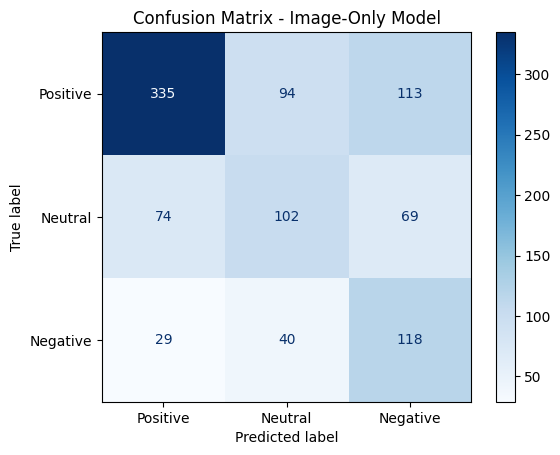

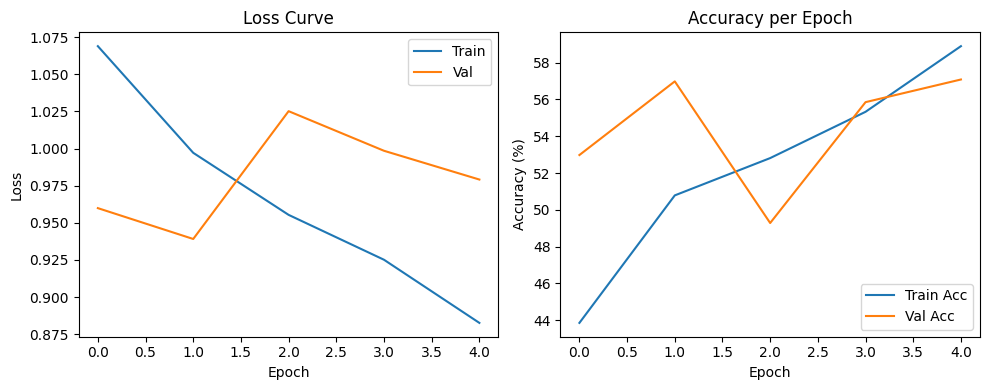

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Print classification report
print(f"\nText-Only Final Val Acc: {accuracy_score(all_labels_img, all_preds_img)*100:.2f}%")
target_names = ['Positive', 'Neutral', 'Negative']  # Replace with actual class names if known
report = classification_report(all_labels_img, all_preds_img, target_names=target_names, digits=4)
print("📊 Classification Report:\n")
print(report)


# Confusion Matrix
cm = confusion_matrix(all_labels_img, all_preds_img)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Image-Only Model")
plt.show()

# Loss curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot([a*100 for a in train_accs], label='Train Acc')
plt.plot([a*100 for a in val_accs],   label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch');
plt.ylabel('Accuracy (%)');
plt.legend()
plt.tight_layout()
plt.show()

**Interepretation**

The curves though do not look right are going towards the same direction which implies that they might converge with more epochs. The accuracy curves also show convergence towards the end. Even though the validation accuracy falls at first it recovers and goes back up.

## 7️⃣ Part B: Text-Only Model (RNN/LSTM)

Next, we will build a model that uses only the text from the tweets.

### 7.1 Define the RNN/LSTM Architecture
**Task**: Create a text classification model using an Embedding layer and an LSTM/GRU layer.

**Requirements**:
- An `nn.Embedding` layer to convert word indices to dense vectors.
- An `nn.LSTM` or `nn.GRU` layer to process the sequence.
- A final `nn.Linear` layer to produce class scores.

In [ ]:
# TODO: Define the TextModel class inheriting from nn.Module.
#       In __init__:
#       - Create an nn.Embedding layer (vocab_size, embedding_dim).
#       - Create an nn.LSTM or nn.GRU layer.
#       - Create a nn.Linear layer for the output classification (hidden_dim -> 3).
#       In forward(self, text):
#       - Pass text through embedding layer.
#       - Pass embeddings through LSTM/GRU.
#       - Use the final hidden state of the LSTM/GRU for classification.
#       - Pass the hidden state through the linear layer.

# TODO: Initialize the text model and move it to the device.
# TODO: Print the model architecture.

In [ ]:
# 1️⃣ Define model, loss, optimizer, scheduler
from transformers import BertModel
import torch.nn as nn

class TextOnlyModel(nn.Module):
    def __init__(self, num_classes=3, dropout_p=0.5):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        hid = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(hid, hid//2), nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hid//2, num_classes)
        )
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        return self.classifier(out)

model_txt   = TextOnlyModel().to(device)
print(model_txt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TextOnlyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

### 7.2 Train and Evaluate the Text Model
**Task**: Train and evaluate the text-only model using the same process as before.

In [ ]:
# TODO: Instantiate the loss function and optimizer for the text model.

# TODO: Write the training loop for the text model.
#       For each batch in train_loader:
#       - Get texts and labels, move them to the device.
#       - Train the model (forward pass, loss, backward pass, optimizer step).

# TODO: Write the evaluation loop for the text model on the validation set.

# TODO: Calculate and print the final validation accuracy.
# TODO: Generate and plot a confusion matrix for the text model.

Epoch [1/20]  Train Loss: 0.9758 Acc: 51.45%  |  Val Loss: 0.6922 Acc: 72.38%
Epoch [2/20]  Train Loss: 0.6609 Acc: 74.45%  |  Val Loss: 0.6407 Acc: 73.51%
Epoch [3/20]  Train Loss: 0.4654 Acc: 83.44%  |  Val Loss: 0.6497 Acc: 72.69%
Epoch [4/20]  Train Loss: 0.3122 Acc: 89.99%  |  Val Loss: 0.7068 Acc: 75.26%
Epoch [5/20]  Train Loss: 0.1928 Acc: 94.69%  |  Val Loss: 0.7738 Acc: 74.95%
⏹ Early stopping at epoch 5

Text-Only Final Val Acc: 73.51%

Classification Report:
               precision    recall  f1-score   support

    positive       0.78      0.81      0.79       346
    negative       0.62      0.83      0.71       244
     neutral       0.81      0.61      0.69       384

    accuracy                           0.74       974
   macro avg       0.74      0.75      0.73       974
weighted avg       0.75      0.74      0.73       974



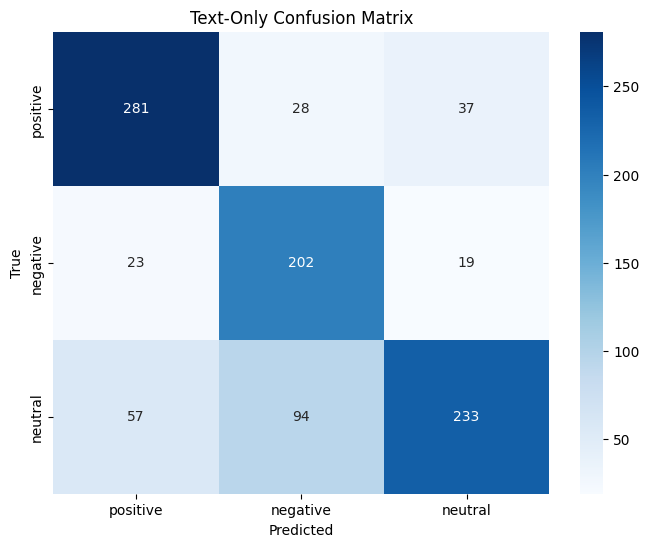

In [ ]:
# 3️⃣ Loss, Optimizer, Scheduler, Early Stopping

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_txt.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)

best_val_loss = float('inf')
wait, patience = 0, 3

# ────────────────────────────────
# 4️⃣ Training Loop

train_losses_txt = []
val_losses_txt   = []
train_accs_txt   = []
val_accs_txt     = []

for epoch in range(1, NUM_EPOCHS+1):
    # — Train
    model_txt.train()
    running_loss = 0.0
    correct = total = 0
    for ids, masks, labels in train_txt_loader:
        ids, masks, labels = ids.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_txt(ids, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss_txt = running_loss / total
    train_acc_txt  = correct / total
    train_losses_txt.append(train_loss_txt)
    train_accs_txt.append(train_acc_txt)

    # — Validate
    model_txt.eval()
    running_loss = correct = total = 0
    all_labels_txt, all_preds_txt = [], []
    with torch.no_grad():
        for ids, masks, labels in val_txt_loader:
            ids, masks, labels = ids.to(device), masks.to(device), labels.to(device)
            outputs = model_txt(ids, masks)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels_txt.extend(labels.cpu().tolist())
            all_preds_txt.extend(preds.cpu().tolist())

    val_loss_txt = running_loss / total
    val_acc_txt  = correct / total
    val_losses_txt.append(val_loss_txt)
    val_accs_txt.append(val_acc_txt)
    scheduler.step(val_loss_txt)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}]  "
          f"Train Loss: {train_loss_txt:.4f} Acc: {train_acc_txt*100:.2f}%  |  "
          f"Val Loss: {val_loss_txt:.4f} Acc: {val_acc_txt*100:.2f}%")

    # Early stopping & checkpoint
    if val_loss_txt < best_val_loss:
        best_val_loss = val_loss_txt
        wait = 0
        torch.save(model_txt.state_dict(), 'best_text_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

# ────────────────────────────────
# 5️⃣ Final Evaluation

model_txt.load_state_dict(torch.load('best_text_model.pt'))
model_txt.eval()

all_labels_txt, all_preds_txt = [], []
with torch.no_grad():
    for ids, masks, labels in val_txt_loader:
        ids, masks = ids.to(device), masks.to(device)
        outputs = model_txt(ids, masks)
        all_preds_txt.extend(outputs.argmax(1).cpu().tolist())
        all_labels_txt.extend(labels.tolist())

print(f"\nText-Only Final Val Acc: {accuracy_score(all_labels_txt, all_preds_txt)*100:.2f}%")
print("\nClassification Report:\n",
      classification_report(all_labels_txt, all_preds_txt, target_names=['positive','negative','neutral']))

cm = confusion_matrix(all_labels_txt, all_preds_txt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','negative','neutral'], yticklabels=['positive','negative','neutral'])
plt.title('Text-Only Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

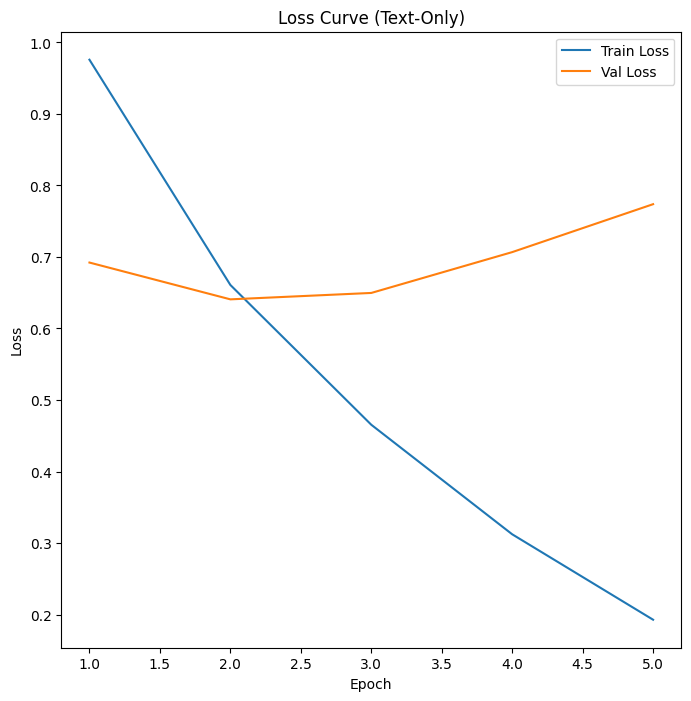

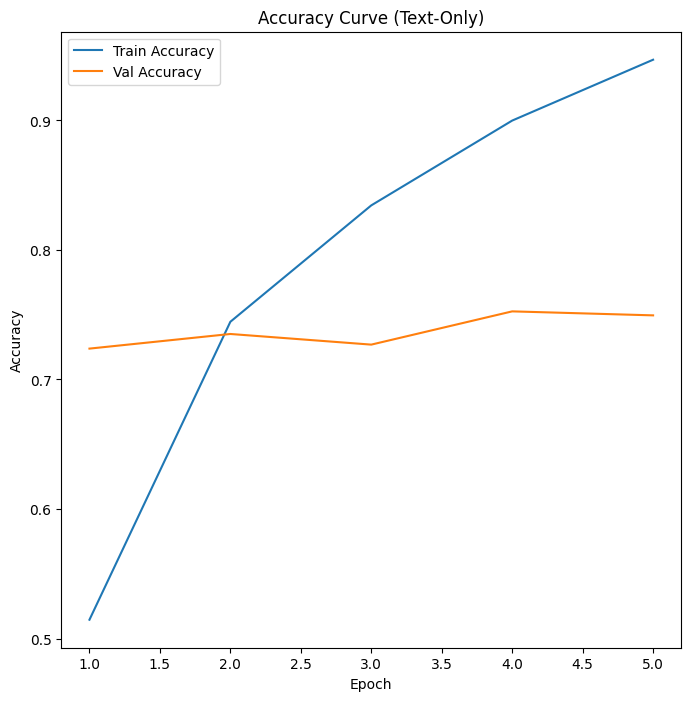

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses_txt) + 1)

# 📉 Plot Loss
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_losses_txt, label='Train Loss')
plt.plot(epochs, val_losses_txt, label='Val Loss')
plt.title('Loss Curve (Text-Only)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 📈 Plot Accuracy
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_accs_txt, label='Train Accuracy')
plt.plot(epochs, val_accs_txt, label='Val Accuracy')
plt.title('Accuracy Curve (Text-Only)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 8️⃣ Part C: Combined Multimodal Model

Finally, we'll combine the two feature extractors into a single, powerful model.

### 8.1 Define the Multimodal Architecture
**Task**: Create a model that takes both an image and text as input.

**Requirements**:
- Use the pre-trained image CNN (without its final classifier layer) as an image feature extractor.
- Use the trained text model (without its final classifier layer) as a text feature extractor.
- Concatenate the features from both branches.
- Add one or more `nn.Linear` layers to classify the combined feature vector.

In [ ]:
# TODO: Define the MultiModalModel class inheriting from nn.Module.
#       In __init__:
#       - Instantiate your image feature extractor (e.g., ResNet without the last layer).
#       - Instantiate your text feature extractor (e.g., Embedding + LSTM).
#       - Define a new classifier (nn.Sequential with Linear, ReLU, Dropout, Linear)
#         that takes the concatenated feature dimension as input.
#       In forward(self, image, text):
#       - Get image features.
#       - Get text features.
#       - Concatenate the features (torch.cat).
#       - Pass the combined features through the new classifier.
#       - Return the final logits.

# TODO: Initialize the multimodal model and move it to the device.
# TODO: Print the model architecture.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel

class MultiModalModel(nn.Module):
    def __init__(self, num_classes=3, dropout_p=0.5, freeze_backbones=True):
        super().__init__()
        # ─── Image branch ─────────────────────────────────────────
        resnet = models.resnet18(pretrained=True)
        img_dim = resnet.fc.in_features
        resnet.fc = nn.Identity()                # drop the old FC
        self.image_encoder = resnet

        # ─── Text branch ──────────────────────────────────────────
        bert = BertModel.from_pretrained('bert-base-uncased')
        txt_dim = bert.config.hidden_size
        self.text_encoder = bert

        # ─── Optionally freeze all pretrained weights ─────────────
        if freeze_backbones:
            for p in self.image_encoder.parameters():
                p.requires_grad = False
            for p in self.text_encoder.parameters():
                p.requires_grad = False

        # ─── Fusion head ──────────────────────────────────────────
        fusion_dim = img_dim + txt_dim
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(fusion_dim // 2, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # encode image
        img_feat = self.image_encoder(images)                      # (B, img_dim)
        # encode text
        txt_out = self.text_encoder(input_ids=input_ids,
                                    attention_mask=attention_mask)
        txt_feat = txt_out.pooler_output                           # (B, txt_dim)
        # fuse
        x = torch.cat([img_feat, txt_feat], dim=1)                 # (B, img_dim+txt_dim)
        return self.fusion(x)

# ─── Instantiate & inspect ─────────────────────────────────────
model_mm = MultiModalModel(num_classes=3, dropout_p=0.5, freeze_backbones=True)
model_mm.to(device)
print(model_mm)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiModalModel(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
# ── Multimodal model: ResNet-18 (image) + BERT (text) → MLP head
import torch
import torch.nn as nn
from torchvision.models import resnet18
from transformers import AutoModel

class MultimodalNet(nn.Module):
    def __init__(self, num_classes: int, text_model_name: str = "bert-base-uncased",
                 img_trainable: bool = False, txt_trainable: bool = False):
        super().__init__()

        # Image encoder
        self.img_backbone = resnet18(weights="IMAGENET1K_V1")
        in_feats = self.img_backbone.fc.in_features
        self.img_backbone.fc = nn.Identity()
        for p in self.img_backbone.parameters():
            p.requires_grad = img_trainable
        self.img_proj = nn.Linear(in_feats, 256)

        # Text encoder (BERT)
        self.txt_backbone = AutoModel.from_pretrained(text_model_name)
        txt_dim = self.txt_backbone.config.hidden_size
        for p in self.txt_backbone.parameters():
            p.requires_grad = txt_trainable
        self.txt_proj = nn.Linear(txt_dim, 256)

        # Fusion + head
        self.classifier = nn.Sequential(
            nn.Linear(256 + 256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # Image forward
        img_feat = self.img_backbone(images)          # [B, 512]
        img_feat = self.img_proj(img_feat)            # [B, 256]

        # Text forward (use CLS pooled output)
        txt_out = self.txt_backbone(input_ids=input_ids, attention_mask=attention_mask)
        # Prefer pooler_output when available; fallback to CLS token
        if hasattr(txt_out, "pooler_output") and txt_out.pooler_output is not None:
            txt_feat = txt_out.pooler_output          # [B, hidden]
        else:
            txt_feat = txt_out.last_hidden_state[:, 0, :]  # [B, hidden]
        txt_feat = self.txt_proj(txt_feat)            # [B, 256]

        fused = torch.cat([img_feat, txt_feat], dim=1) # [B, 512]
        logits = self.classifier(fused)                 # raw logits
        return logits

model_mm = MultimodalNet(num_classes=3, text_model_name="bert-base-uncased",
                         img_trainable=True, txt_trainable=True)
model_mm.to(device)
print(model_mm)

MultimodalNet(
  (img_backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### 8.2 Train and Evaluate the Multimodal Model
**Task**: Train and evaluate the final combined model.

In [ ]:
# TODO: Instantiate the loss function and optimizer for the multimodal model.

# TODO: Write the training loop for the multimodal model.
#       For each batch in train_loader:
#       - Get images, texts, and labels, move them to the device.
#       - Train the model (forward pass, loss, backward pass, optimizer step).

# TODO: Write the evaluation loop for the multimodal model on the validation set.

# TODO: Calculate and print the final validation accuracy.
# TODO: Generate and plot a confusion matrix for the multimodal model.

In [ ]:
print(len(train_mm_loader), len(val_mm_loader))

196 14


In [ ]:
# ────────────────────────────────
# 3️⃣ Loss, Optimizer, Scheduler, Early Stopping

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_mm.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=1, factor=0.5, verbose=True)

best_val_loss = float('inf')
wait, patience = 0, 3

# ────────────────────────────────
# 4️⃣ Training Loop

train_losses_mm = []
val_losses_mm   = []
train_accs_mm   = []
val_accs_mm     = []

for epoch in range(1, NUM_EPOCHS + 1):

    # — Train —
    model_mm.train()
    running_loss = correct = total = 0

    for batch in train_mm_loader:
        # unpack either 4-tuple or 3-tuple
        if len(batch) == 4:
            images, input_ids, attention_mask, labels = batch
        else:  # (images, input_ids, labels)
            images, input_ids, labels = batch
            attention_mask = torch.ones_like(input_ids)

        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_mm(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss_mm = running_loss / total
    train_acc_mm  = correct / total
    train_losses_mm.append(train_loss_mm)
    train_accs_mm.append(train_acc_mm)

    # — Validate —
    model_mm.eval()
    running_loss = correct = total = 0
    all_labels_mm = []
    all_preds_mm  = []

    with torch.no_grad():
        for batch in val_mm_loader:
            if len(batch) == 4:
                images, input_ids, attention_mask, labels = batch
            else:
                images, input_ids, labels = batch
                attention_mask = torch.ones_like(input_ids)

            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model_mm(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels_mm.extend(labels.cpu().tolist())
            all_preds_mm.extend(preds.cpu().tolist())

    val_loss_mm = running_loss / total
    val_acc_mm  = correct / total
    val_losses_mm.append(val_loss_mm)
    val_accs_mm.append(val_acc_mm)

    scheduler.step(val_loss_mm)

    print(f"\nEpoch [{epoch}/{NUM_EPOCHS}] | Train Loss: {train_loss_mm:.4f} | Acc: {train_acc_mm*100:.2f}% | Val  Loss: {val_loss_mm:.4f} | Acc: {val_acc_mm*100:.2f}%")

    # Early stopping & checkpoint
    if val_loss_mm < best_val_loss:
        best_val_loss = val_loss_mm
        wait = 0
        torch.save(model_mm.state_dict(), 'best_multimodal_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

# ────────────────────────────────
# 5️⃣ Final Evaluation & Plots

# Load best weights
model_mm.load_state_dict(torch.load('best_multimodal_model.pt'))
model_mm.eval()


Epoch [1/20] | Train Loss: 0.9245 | Acc: 55.68% | Val  Loss: 0.7373 | Acc: 72.30%

Epoch [2/20] | Train Loss: 0.6380 | Acc: 74.86% | Val  Loss: 0.5369 | Acc: 79.34%

Epoch [3/20] | Train Loss: 0.4418 | Acc: 84.75% | Val  Loss: 0.5904 | Acc: 76.06%

Epoch [4/20] | Train Loss: 0.2683 | Acc: 91.45% | Val  Loss: 0.6742 | Acc: 76.06%

Epoch [5/20] | Train Loss: 0.1539 | Acc: 95.76% | Val  Loss: 0.7213 | Acc: 77.00%
⏹ Early stopping at epoch 5


MultimodalNet(
  (img_backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True


Text-Only Final Val Acc: 77.00%

Classification Report:
               precision    recall  f1-score   support

    positive       0.80      0.84      0.82        73
    negative       0.77      0.65      0.70        57
     neutral       0.74      0.80      0.77        83

    accuracy                           0.77       213
   macro avg       0.77      0.76      0.76       213
weighted avg       0.77      0.77      0.77       213



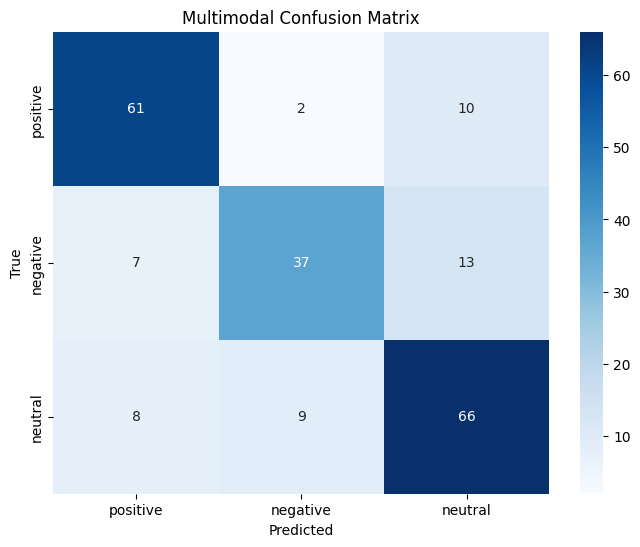

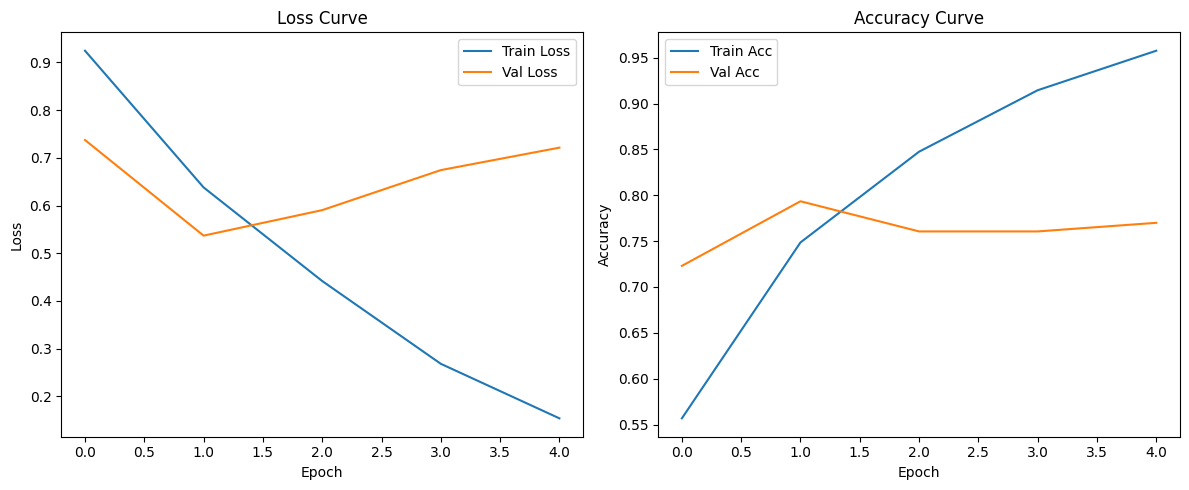

In [ ]:
# Classification report & confusion matrix
print(f"\nText-Only Final Val Acc: {accuracy_score(all_labels_mm, all_preds_mm)*100:.2f}%")
print("\nClassification Report:\n",
      classification_report(all_labels_mm, all_preds_mm, target_names=['positive','negative','neutral']))

cm = confusion_matrix(all_labels_mm, all_preds_mm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','negative','neutral'], yticklabels=['positive','negative','neutral'])
plt.title('Multimodal Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# Loss & accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_mm, label='Train Loss')
plt.plot(val_losses_mm,   label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_mm, label='Train Acc')
plt.plot(val_accs_mm,   label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 9️⃣ Performance Comparison

**Task**: Present the results of all three models side-by-side.

**Requirements**:
- Display the final validation accuracies for the Image-Only, Text-Only, and Multimodal models.
- Plot the confusion matrices for all three models in a single figure for easy comparison.

In [ ]:
# TODO: Print the final validation accuracies for all three models in a summary table or list.

# TODO: Create a 1x3 subplot using matplotlib.
# TODO: Plot the confusion matrix for the image model in the first subplot.
# TODO: Plot the confusion matrix for the text model in the second subplot.
# TODO: Plot the confusion matrix for the multimodal model in the third subplot.
# TODO: Add titles to each subplot.
# TODO: Display the final plot.

In [ ]:
print(f"\nImage-Only Final Val Acc: {accuracy_score(all_labels_img, all_preds_img)*100:.2f}%")
print(f"\nText-Only Final Val Acc: {accuracy_score(all_labels_txt, all_preds_txt)*100:.2f}%")
print(f"\nMulti-Model Final Val Acc: {accuracy_score(all_labels_mm, all_preds_mm)*100:.2f}%")


Image-Only Final Val Acc: 56.98%

Text-Only Final Val Acc: 73.51%

Multi-Model Final Val Acc: 77.00%


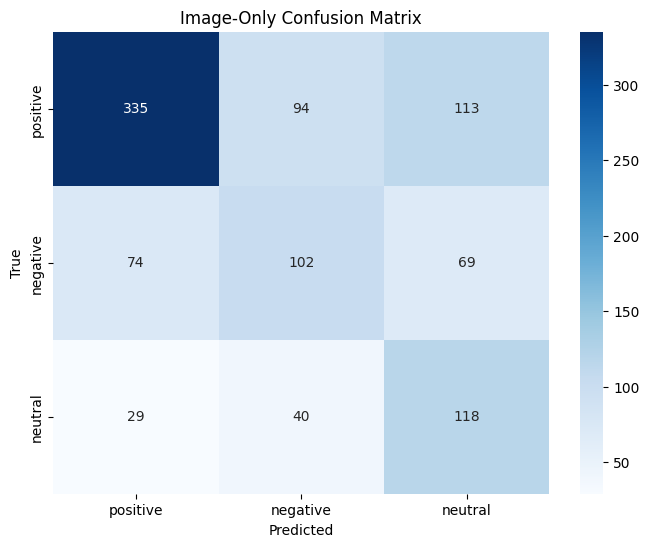

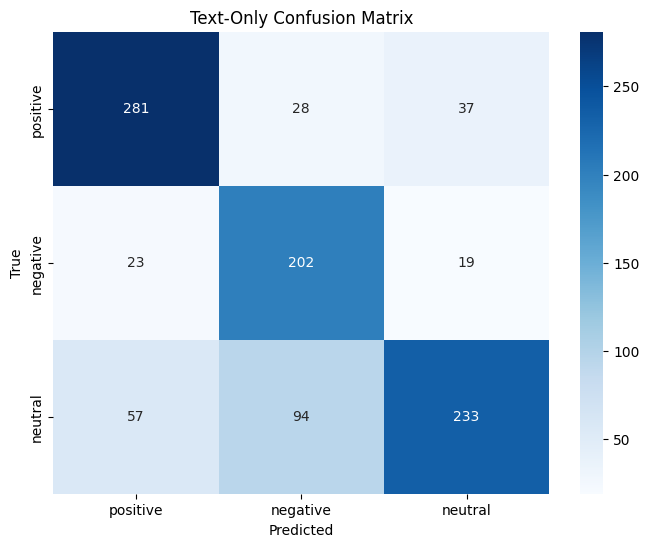

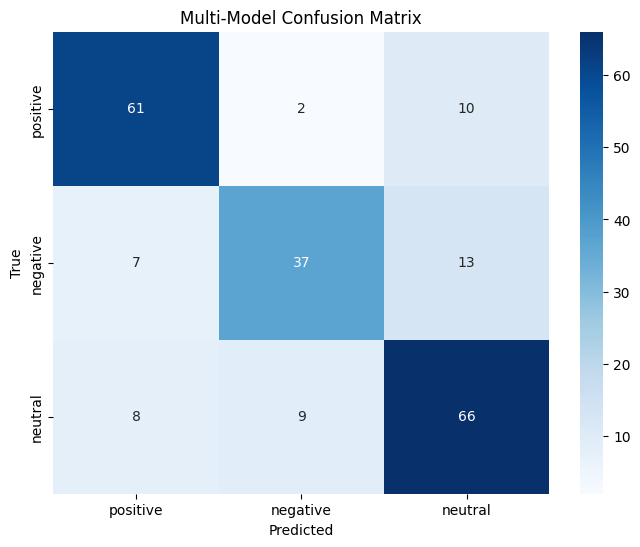

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


cm = confusion_matrix(all_labels_img, all_preds_img)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','negative','neutral'], yticklabels=['positive','negative','neutral'])
plt.title('Image-Only Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

cm = confusion_matrix(all_labels_txt, all_preds_txt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','negative','neutral'], yticklabels=['positive','negative','neutral'])
plt.title('Text-Only Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

cm = confusion_matrix(all_labels_mm, all_preds_mm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','negative','neutral'], yticklabels=['positive','negative','neutral'])
plt.title('Multi-Model Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


##Notes
*   I used BERT because of its contextual understanding (negation, intensifiers, sarcasm).
*   By making the data harder to process (heavier augmentation/regularization), we reduced overfitting, which led to cleaner, diagonal confusion matrices.
*   Even with modest overall accuracy, the diagonal shows the model learned meaningful structure and still classified non-trivially.
*   The text model did the better than image because text is easier to classify than image
*   For the multimodel, a custom data set was created after a lot of trial and error which pairs image and text samples and takes both into account unlike the previous dataset which only took text.

##Multimodel
It performed best out of all of the models but was only able to classfiy tweets when the image and text was paired together, otherwise it got very confused and was not able to perform well.

##Conclusion

This clearly showed that the models were a lot better when text was involved as compared to just the images. This could be because images are more subjective as compared to text.


## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1.  **Implementation Correctness (40%)**
    - Correct implementation of all three model architectures (CNN, RNN/LSTM, Combined).
    - Proper data loading, preprocessing, and splitting.
    - Working training and evaluation loops for each model.

2.  **Model Training and Results (30%)**
    - All three models train without errors.
    - Loss decreases over epochs.
    - Final models produce reasonable predictions on the validation set.

3.  **Code Quality (20%)**
    - Clean, readable code with comments explaining key parts.
    - Correct use of PyTorch modules, tensor shapes, and data flow.
    - Efficient implementation.

4.  **Comparison and Visualization (10%)**
    - Clear presentation of final accuracies for all models.
    - Correctly generated and clearly labeled confusion matrices for comparison.

# Written by: Ali Habibullah